## Summary

1. JAX Arrays are immutable.
2. JAX relies on functional programming.
3. JAX generates random numbers in a different way.
4. JAX is not stateful, we have to pass the state explicitly.
5. JAX is accelerator agnositic.

In [ ]:
from jax import random, device_put, jit, grad, vmap, lax, make_jaxpr
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Dot Product Impact

In [ ]:
size = 3000
seed = 1432
key = random.PRNGKey(seed)


x_jnp = random.normal(key, (size, size), dtype=jnp.float32) # JAX Array
x_np = np.random.normal(size=(size, size)).astype(np.float32) # Numpy Array



%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready() # 1 - on GPU -> Fast
%timeit np.dot(x_np, x_np.T) # 2 - on CPU -> Slow (numpy array only works on CPU's)
%timeit jnp.dot(x_np, x_np.T).block_until_ready() # 3 - on GPU with transfer overhead from numpy array to jax array


x_np_device = device_put(x_np) # push numpy array explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready() # same as 1

12.6 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
435 ms ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.8 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.5 ms ± 51.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## JIT (`jit`)

In [ ]:
def visualize_fn(fn, l=-10, r=10, n=1000):
  x = np.linspace(l, r, num=n)
  y = fn(x)
  plt.plot(x, y)
  plt.show()

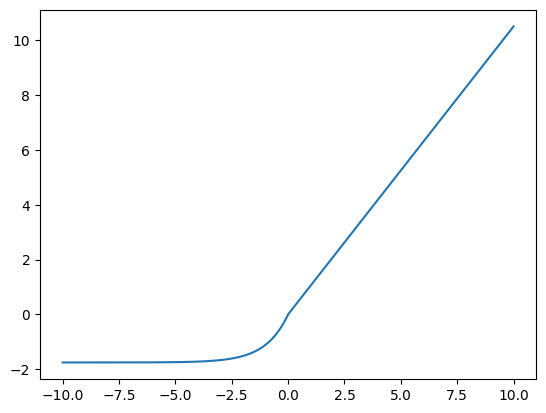

non-jit version:
3.17 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jit version:
519 µs ± 6.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
def selu(x, alpha=1.67, lmbda=1.05): # selu an activation function
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)


selu_jit = jit(selu) # let make compile it using jit

visualize_fn(selu)

# Benchmark non-jit vs jit version
data = random.normal(key, (10000000, ))

print('non-jit version:')
%timeit selu(data).block_until_ready()

print('jit version:')
%timeit selu_jit(data).block_until_ready()

In [ ]:
# Example of failure: array shapes must be static

def get_negatives(x):
  return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))

print(jit(get_negatives)(x))

[-0.24197772 -1.2128664  -1.6509197  -0.47618896 -0.0655551  -0.9115017 ]


NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [ ]:
# So how does it work in the background ? -> tracing on different levels of abstraction

@jit
def f(x,y):
  print("Running f():")
  print(f" x = {x}")
  print(f" y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f" resut = {result}")
  return result


x = np.random.randn(3, 4)
y = np.random.randn(4)


print(f(x, y))



x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)


print("Second Call:")
print(f(x2, y2))



# Note: any time we get the same shape and types we just call the compiled fn!

Running f():
 x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
 y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
 resut = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[5.0836024  0.82231104 4.2362638 ]
Second Call:
[ 4.64573    5.0731072 -0.2917766]


In [ ]:
def f(x, y):
  return jnp.dot(x+1, y+1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


In [ ]:
# 2nd example of a failure
@jit
def f(x, neg): # depends on the value - remember tracer cares about shapes and types!
  return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at <ipython-input-56-a566844e1580>:2 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [ ]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  print(x)
  return -x if neg else x

print(f(1, False))
print(f(2, True))
print(f(2, False))
print(f(23, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
1
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-2
2
23


In [ ]:
# 3rd example of failure:

@jit
def f(x):
  print(x)
  print(x.shape)
  print(jnp.array(x.shape).prod())
  return x.reshape(jnp.array(x.shape).prod())


x = jnp.ones((2, 3))
f(x)

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=1/0)>
(2, 3)
Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>


TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function f at <ipython-input-63-cdb929e8d983>:3 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[2] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line <ipython-input-63-cdb929e8d983>:8 (f)

In [ ]:
@jit
def f(x):
  return x.reshape((np.prod(x.shape),))

f(x)

Array([1., 1., 1., 1., 1., 1.], dtype=float32)

## GRAD (`grad`)

Differentation can be:
  * manual
  * symbolic
  * numeric
  * autmatic! (all deep learning frameworks use this)


  **BY default grad calculates the derivate of fn w.r.t 1st paramter!**

In [ ]:
def sum_logistic(x): # any other simple differentable function
  return jnp.sum(1.0 / 1.0 + jnp.exp(-x))

def sum_of_squares(x):
  return jnp.sum(x**2)

x = jnp.arange(3.)
print(x)
loss = sum_logistic

# BY default grad calculates the deriate of fn w.r.t 1st paramter!
# Here we bundled inputs into a 1st param so it doesn't matter
grad_loss = grad(loss)

print("Sum of Logistic Derivative Loss:", grad_loss(x))
print("Summ of Squares Derivative Loss:", grad(sum_of_squares)(x))

[0. 1. 2.]
Sum of Logistic Derivative Loss: [-1.         -0.36787948 -0.13533528]
Summ of Squares Derivative Loss: [0. 2. 4.]


In [ ]:
x = 1.
y = 1.
f = lambda x, y: x**2 + x + 4 + y**2

# visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f, argnums=(1)) # 2*x + 1 # f will be derivated using first argument which is x
d2fdx = grad(dfdx) # 2
d3fdx = grad(d2fdx) # 0

print(f(x, y), dfdx(x, y), d2fdx(x, y), d3fdx(x, y))


# What if we have two inputs

# Note1: Closer to math!
# Note2: More powerful compared to backward() (Pytorch syntax)

7.0 2.0 0.0 0.0


## Jacobian

* Can evaluate derivatives for vector valued functions

In [ ]:
from jax import jacfwd, jacrev


f = lambda x,y: x**2 + y**2

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]


def hessian(f):
  return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums=(0, 1)))


print(f"Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}")
print(f"Full Hessian = {hessian(f)(1., 1.)}")

Jacobian = (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Full Hessian = ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


In [ ]:
# Edge case |x|, how does JAX handle it

f = lambda x: abs(x)

print(f(-1), f(1))

dfdx = grad(f)

print(dfdx(-0.8)) # zero to positive return positive, even zero returns 1 for all other negative values negative

1 1
-1.0


## VMAP (`vmap`)

**Write your functions as if you were dealing with a single datapoint**

* It batches a function for you

In [ ]:
W = random.normal(key, (150, 100))

batched_x = random.normal(key, (10, 100)) # a batch of 10 flattened images

def apply_matrix(W, x):
  return jnp.dot(W, x) # (150, 100) * (10, 100) -> fail as we are only doing dot for one image

In [ ]:
def naively_batched_apply_matrix(W, batched_x):
  return jnp.stack([apply_matrix(W, x) for x in batched_x])

print("Naively batched")
%timeit naively_batched_apply_matrix(W, batched_x).block_until_ready()

Naively batched
2.97 ms ± 82.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
@jit
def batched_apply_matrix(W, batched_x):
  return jnp.dot(batched_x, W.T) #(10, 100) * (100, 150) -> (10, 150)


print("Manually batched")
%timeit batched_apply_matrix(W, batched_x).block_until_ready()

Manually batched
108 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
@jit
def vmap_batched_apply_matrix(W, batched_x):
  return vmap(apply_matrix, in_axes=(None, 0))(W, batched_x)


print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(W, batched_x)

Auto-vectorized with vmap
58.2 µs ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## JAX Onion Structured apis

* Numpy <-> lax <-> XLA
* lax API is stricter and more powerful
* It's python wrapper around XLA

In [ ]:
# Example 1: lax is stricter

print(jnp.add(1, 1.0)) # jax.numpy API implicityly promotes mixed types
print(lax.add(1, 1.0)) # lax API has strict datatypes

2.0


ValueError: Cannot lower jaxpr with verifier errors:
	'stablehlo.add' op requires compatible types for all operands and results
		at loc("jit(add)/jit(main)/add"("<ipython-input-45-9b91b363f362>":4:0))
	see current operation: %0 = "stablehlo.add"(%arg0, %arg1) : (tensor<i32>, tensor<f32>) -> tensor<i32>
		at loc("jit(add)/jit(main)/add"("<ipython-input-45-9b91b363f362>":4:0))
Module string:
#loc1 = loc("args[0]")
#loc2 = loc("args[1]")
"builtin.module"() <{sym_name = "jit_add"}> ({
  "func.func"() <{arg_attrs = [{mhlo.layout_mode = "default", mhlo.sharding = "{replicated}"}, {mhlo.layout_mode = "default", mhlo.sharding = "{replicated}"}], function_type = (tensor<i32>, tensor<f32>) -> tensor<i32>, res_attrs = [{jax.result_info = "", mhlo.layout_mode = "default"}], sym_name = "main", sym_visibility = "public"}> ({
  ^bb0(%arg0: tensor<i32> loc("args[0]"), %arg1: tensor<f32> loc("args[1]")):
    %0 = "stablehlo.add"(%arg0, %arg1) : (tensor<i32>, tensor<f32>) -> tensor<i32> loc(#loc4)
    "func.return"(%0) : (tensor<i32>) -> () loc(#loc)
  }) : () -> () loc(#loc)
}) {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32} : () -> () loc(#loc)
#loc = loc(unknown)
#loc3 = loc("<ipython-input-45-9b91b363f362>":4:0)
#loc4 = loc("jit(add)/jit(main)/add"(#loc3))


In [ ]:
# Example 2: lax is more powerful (but as a tradeoff less user-friendly)

x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# Numpy api
result1 = jnp.convolve(x, y)


# lax API
result2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float), # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)] # equivalent of padding='full' in NumPy
)

print(result1)
print(result2[0][0])

assert np.allclose(result1, result2[0][0], atol=1e-6)

[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]
[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]


## Pure functions

* JAX is designed to work only on pure functions

Pure function? Informal definition:
1. All the input data is passed through the function parameters, all the results are output through the function results.
2. A pure function will always return the same result if invoked with the same inputs.

In [ ]:
# Example 1

def impure_print_side_effect(x):
  print("Executing function") # Voilating # 1
  return x


print(f"First call: {jit(impure_print_side_effect)(4.)}")
print(f"Second call: {jit(impure_print_side_effect)(5.)}")

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now involes a caced compiled version of the function
print("Third call:", jit(impure_print_side_effect)(jnp.array([5.])))



Executing function
First call: 4.0
Second call: 5.0
Executing function
Third call: [5.]


In [ ]:
# Example 2

g = 0.


def impure_uses_globals(x):
  return x + g # Voilating both #1 and #2

print("First call:", jit(impure_uses_globals)(4.))


g = 10.

print("Second call:", jit(impure_uses_globals)(5.))


print("Third call, different type", jit(impure_uses_globals)(jnp.array([4.])))

First call: 4.0
Second call: 5.0
Third call, different type [14.]


In [ ]:
# Example 3: very important! Haiku/Flax are basically built upon this idea!


def pure_uses_internal_state(x):
  state = dict(even=0, odd=0)
  for i in range(10):
    state['even' if i %2 == 0 else 'odd'] += x

  return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(5.))

50.0


## Out-of-Bounds Indexing

Due to JAX's accelerator agonistic approach JAX had to make a non-error behaviour for out of bounds indexing (similarly to how invalid fp arithmetic in NaNs and not an exception)

In [ ]:

try:
  np.arange(10)[11]
except Exception as e:
  print("Exception {}".format(e))



Exception index 11 is out of bounds for axis 0 with size 10


In [ ]:
# JAX behaviour


print(jnp.arange(10).at[11].add(23))
print(jnp.arange(10)[11])

[0 1 2 3 4 5 6 7 8 9]
9


## Dont's

In [ ]:
def permissive_sum(x):
  return jnp.sum(jnp.array(x)) # declaring jnp.array here will have to convert to each and every time the x comes and same can be seen in make_jaxpr


x = list(range(10))

print(make_jaxpr(permissive_sum)(x))

{ lambda ; a:i32[] b:i32[] c:i32[] d:i32[] e:i32[] f:i32[] g:i32[] h:i32[] i:i32[]
    j:i32[]. let
    k:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    l:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    n:i32[] = convert_element_type[new_dtype=int32 weak_type=False] d
    o:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
    p:i32[] = convert_element_type[new_dtype=int32 weak_type=False] f
    q:i32[] = convert_element_type[new_dtype=int32 weak_type=False] g
    r:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
    s:i32[] = convert_element_type[new_dtype=int32 weak_type=False] i
    t:i32[] = convert_element_type[new_dtype=int32 weak_type=False] j
    u:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] k
    v:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] l
    w:i32[1] = broadcast_in_dim[broadcast_dimensions=() shap

## Random Numbers

In [ ]:
print(np.random.random())
print(np.random.random())

np.random.seed(seed)

rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])


_ = np.random.uniform()
rng_state = np.random.get_state()


# Mersenne Twister PRNG is known to have a number of problems (NumPy's imp of PRNG)

0.09975415018458933
0.5045105742464003
(624, 0, 0.0)
(2, 0, 0.0)


In [ ]:
key = random.PRNGKey(seed)
print(key)

print(random.normal(key, shape=(1,)))
print(key)

print(random.normal(key, shape=(1,)))
print(key)

[   0 1432]
[-0.24580441]
[   0 1432]
[-0.24580441]
[   0 1432]


In [ ]:
print("old key", key)

key, subkey = random.split(key)

normal_pseudorandom = random.normal(subkey, shape=(1,))

print(" \--SPLIT--> new key ", key)
print("     \-->new subkey", subkey, "-->normal", normal_pseudorandom)

# Note 1: you can split into more subkeys and not just 1
# Note 2: key, subkey no difference it's only a convetnion

old key [   0 1432]
 \--SPLIT--> new key  [2096557826  314911109]
     \-->new subkey [1145665789 3412182383] -->normal [-0.5498441]


In [ ]:
# JAX enforces single precision! There are simple ways around it though

x = random.uniform(key, (1000,) dtype=jnp.float64)
print(x.dtype) # still it will be float 32 rather than float64